In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ast
import os
import sys
import pymc as pm
import pandas as pd

from pathlib import Path

lib_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'lib'))
print("Lib path:", lib_path)

# Append the absolute path to sys.path
sys.path.append(lib_path)

# Now, try importing onedmodel
from onedmodel import *

Lib path: /Users/guime/projects/SLTforSGD/code/lib


In [2]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

## Plot fraction of trajectories when escaping in 1D

In [3]:
# Initialise
nSGD = 10**3
nsamples = 10**3
shuffle = True
batch_size= 20
lr = 0.01
w0 = 1.8
seed_init = 1
seed_data = 1
nw0 = 2
d1 = 1
d2 = 2
wmax = nw0 * w0
frac_max = 10**-3
model = PolyModel(w0=w0, seed=seed_init, wmax=wmax, wmin=-wmax, d1=d1,d2=d2)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories(model)

/Users/guime/projects/SLTforSGD/code/lib/onedmodel.py:469: RuntimeWarning: divide by zero encountered in log
  log_frac = np.log(fraction)


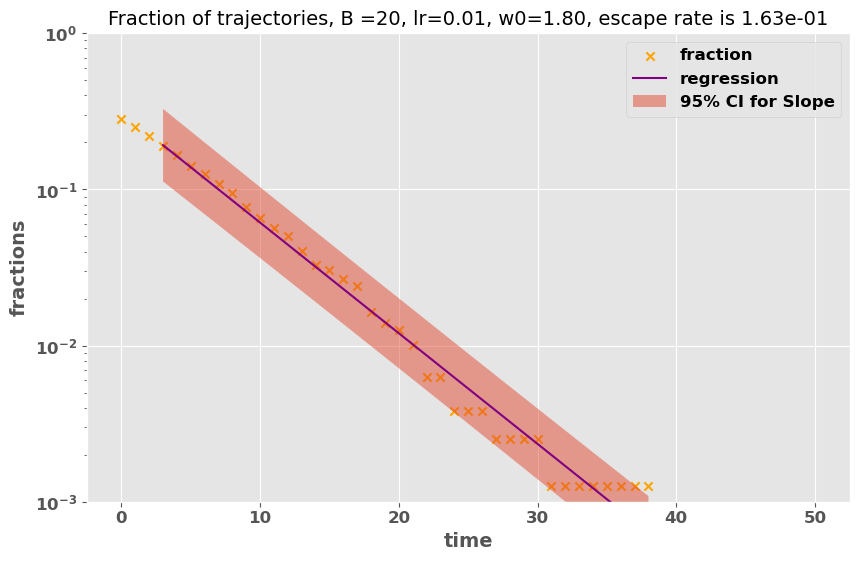

In [4]:
%matplotlib inline
trajectories = np.asarray(df['trajectory'].to_list())
clean_traj = trajectories[~np.isnan(trajectories).any(axis=1)]
fraction = regular_fraction(clean_traj, model)
escape_rate, error = compute_escape_rate(fraction, frac_max=frac_max, tmin=3,
                            batch_size=batch_size, lr=0.01, w0=w0)

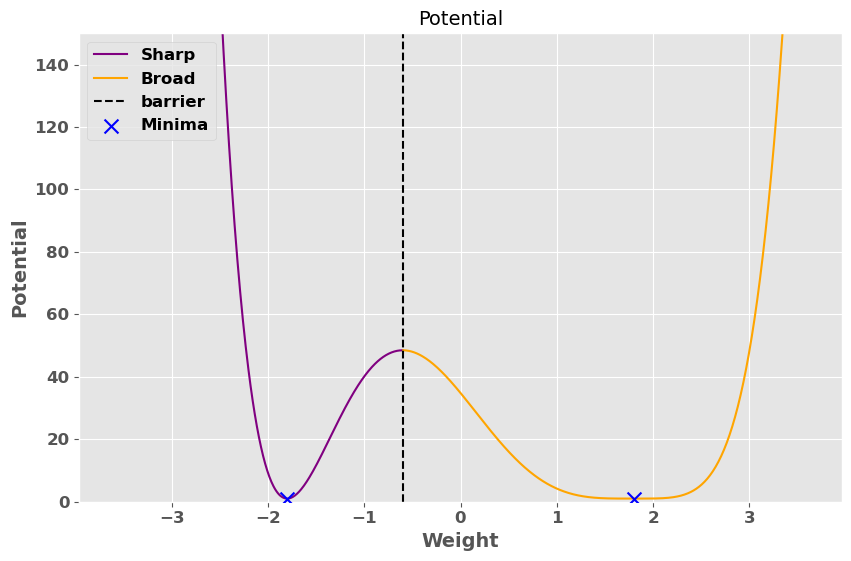

In [5]:
plot_potential(model, nsamp = 10**4, ymax = 150)

Text(0.5, 1.0, 'Distribution of SGD trajectories after 50.0 iterations')

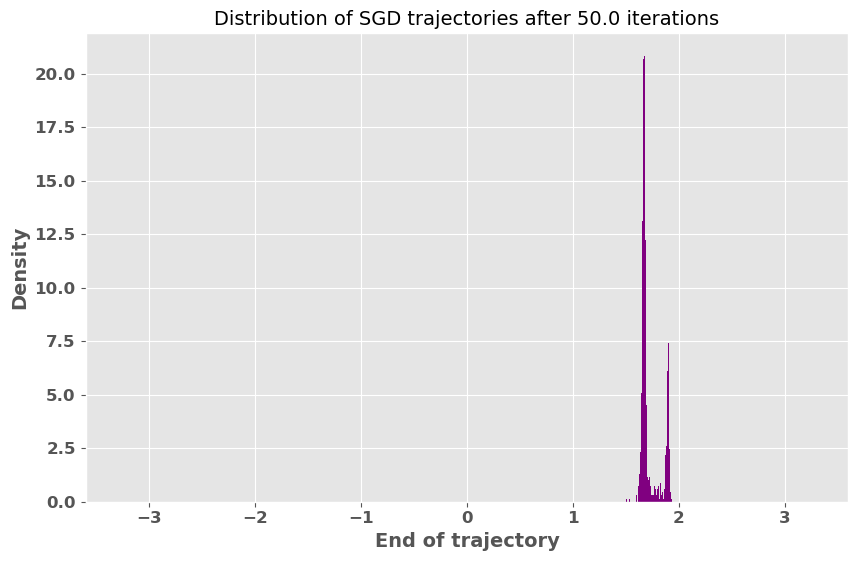

In [6]:
wf = []
for i in range(len(df)):
    wf.append(df["trajectory"][i][-1])
niterations = nSGD/batch_size
plt.hist(wf, bins=50, density=True, color="purple")
plt.xlabel("End of trajectory")
plt.ylabel("Density")
plt.xlim((-wmax, wmax))
plt.title(f"Distribution of SGD trajectories after {niterations} iterations")

## Plot 1D posterior

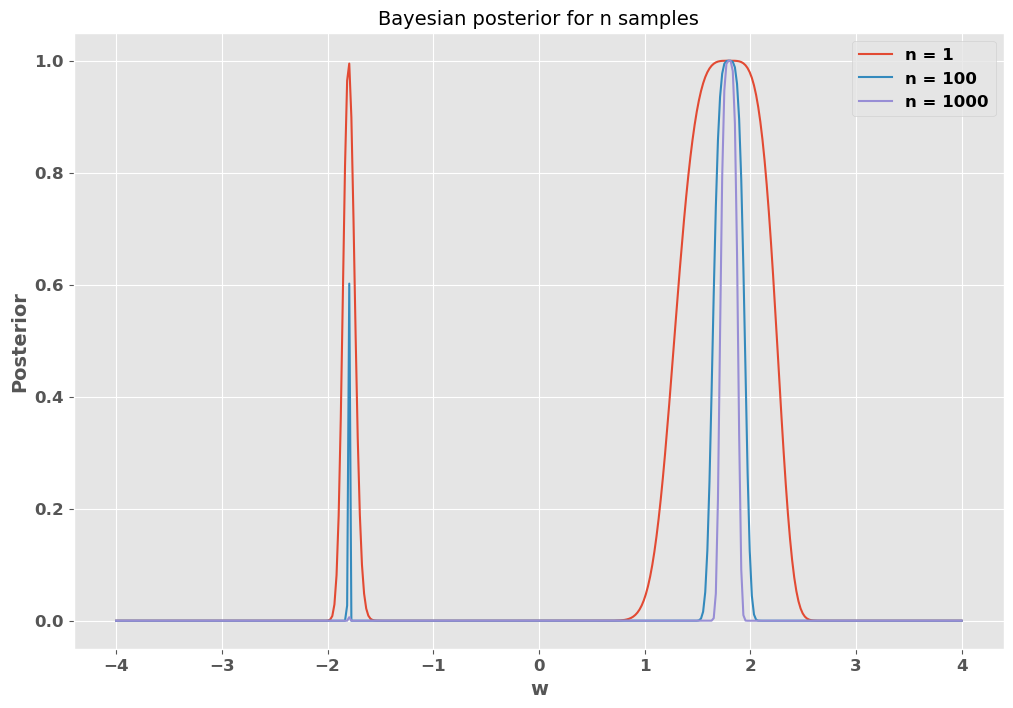

In [106]:
# Exact
n_values = [1, 100, 1000]

w = np.linspace(-4, 4, 400)
K_w = (w - w0)**4 * (w + w0)**2
# Plotting the function for different values of n
plt.figure(figsize=(12, 8))

for n in n_values:
    l = np.exp(-n*K_w)
    plt.plot(w, l, label=f'n = {n}')
plt.title('Bayesian posterior for n samples')
plt.xlabel('w')
plt.ylabel('Posterior')
plt.legend()
plt.grid(True)
plt.yscale("linear")  # Using a logarithmic scale for better visualization
plt.show()


# Distance to most degenerate point

/Users/guime/anaconda3/envs/SLTforSGD/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


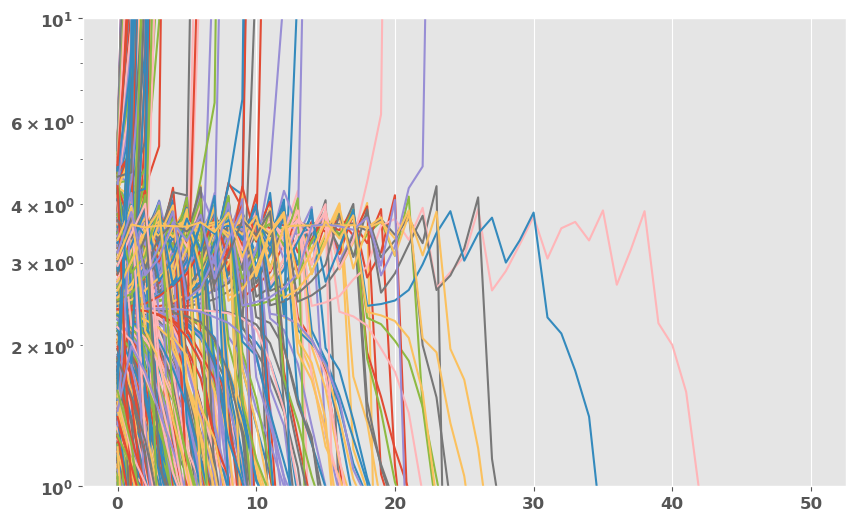

In [8]:
# Get rid of trajetories that diverge. 
niterations = nsamples/batch_size
time = np.arange(0,niterations +1,1)
distance = np.abs((trajectories - w0))
for i in range(distance.shape[0]):
    plt.plot(time, distance[i,:])
    plt.yscale('log')

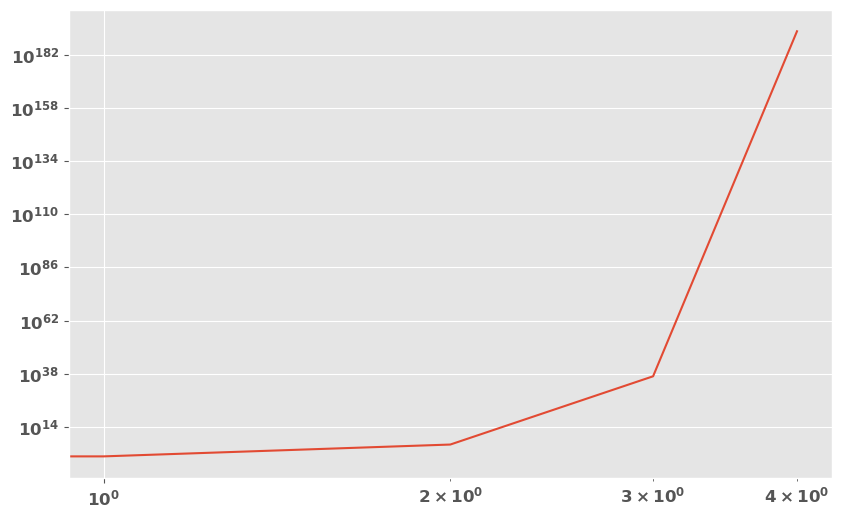

In [9]:
# Plot average distance
mean_distance = np.mean(distance, axis=0)
plt.plot(time, mean_distance)
plt.yscale('log')
plt.xscale('log')

## Plot trajectories when escaping in 2D

In [10]:
# Initialise
nSGD = 10
nsamples = 10**6
shuffle = True
batch_size= 20
lr = 0.01
seed_init = 1
seed_data = 1
wxm = 0
wym = 10
d=1
wx_init = torch.tensor(0.0) 
wy_init = torch.tensor(-10.0)
model = PolyModel2D(seed=seed_init, wxm=wxm, wym=wym, wx_init=wx_init, wy_init = wy_init, d=d)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories2d(model)

5001


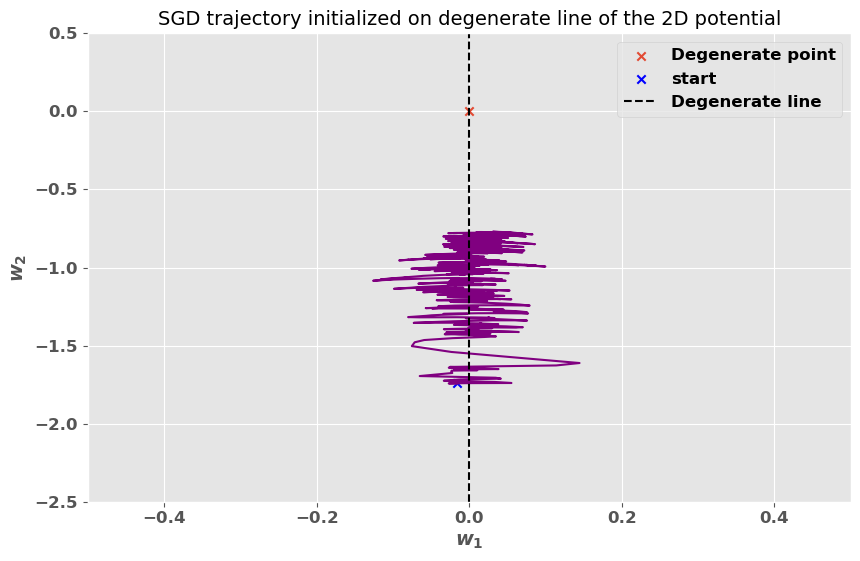

In [51]:
%matplotlib inline
wx = df["trajectory1"][0]
wy = df["trajectory2"][0]
print(len(wx))
fig, ax = plt.subplots()
plt.plot(wx,wy, color='purple')
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.xlim((-0.5, 0.5))
plt.ylim((-2.5, 0.5))
plt.grid(True)
plt.scatter(0,0,marker='x', label="Degenerate point")
plt.scatter(wx[0], wy[0], marker='x', label="start", color='blue')
plt.axvline(x=0, linestyle='--',label = "Degenerate line", color='k')
plt.title("SGD trajectory initialized on degenerate line of the 2D potential")
plt.legend()
plt.show()

# Distribution of SGD trajectories along the degenerate line

In [32]:
# Initialise
nSGD = 10**3
nsamples = 10**4
shuffle = True
batch_size= 20
lr = 0.01
momentum = 0.5
seed_init = 1
seed_data = 1
wxm = 0.1
wym = 5
d=1
wx_init = torch.tensor(0.0) 
wy_init = torch.tensor(-10.0)
model = PolyModel2D(seed=seed_init, wxm=wxm, wym=wym, wx_init=wx_init, wy_init = wy_init, d=d)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, momentum=momentum, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories2d(model)

In [33]:
# Check for infinity and NaN in the array
arr = df["trajectory2"][10]
is_inf = np.isinf(arr)
is_nan = np.isnan(arr)

# Print the elements that are infinity
print("Infinity:")
print(is_inf)

# Print the elements that are NaN
print("NaN:")
print(is_nan)

Infinity:
[False False False ... False False False]
NaN:
[False False False ... False False False]


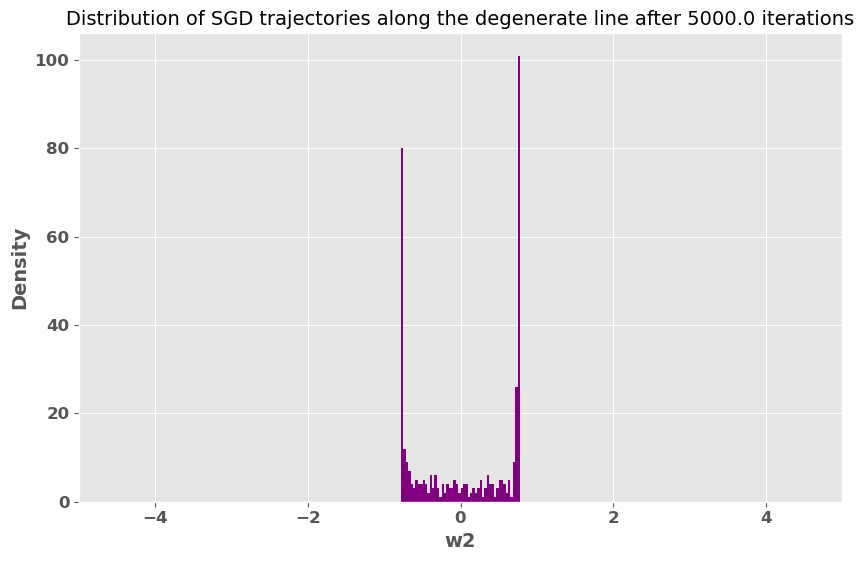

In [109]:
%matplotlib inline
# Histogram of SGD trajectories over the degenerate line
wyf = [0]*nSGD
for i in range(nSGD):
    wyf[i] = df["trajectory2"][i][-1]

niterations = nsamples/batch_size
plt.hist(wyf, bins=50, color='purple')
plt.xlabel("w2")
plt.ylabel("Density")
plt.xlim((-wym, wym))
plt.title(f"Distribution of SGD trajectories along the degenerate line after {niterations} iterations")
plt.show()

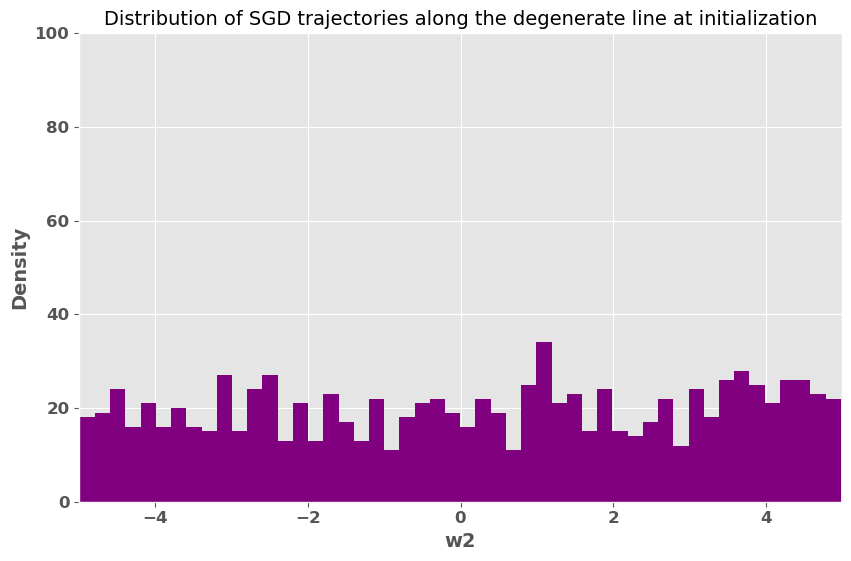

In [107]:
%matplotlib inline
# Histogram of SGD trajectories over the degenerate line
wyf = [0]*nSGD
for i in range(nSGD):
    wyf[i] = df["trajectory2"][i][0]

niterations = nsamples/batch_size
plt.hist(wyf, bins=50, color='purple')
plt.xlabel("w2")
plt.ylabel("Density")
plt.xlim((-wym, wym))
plt.ylim((0,100))
plt.title(f"Distribution of SGD trajectories along the degenerate line at initialization")
plt.show()

# 2D Bayesian posterior on L1

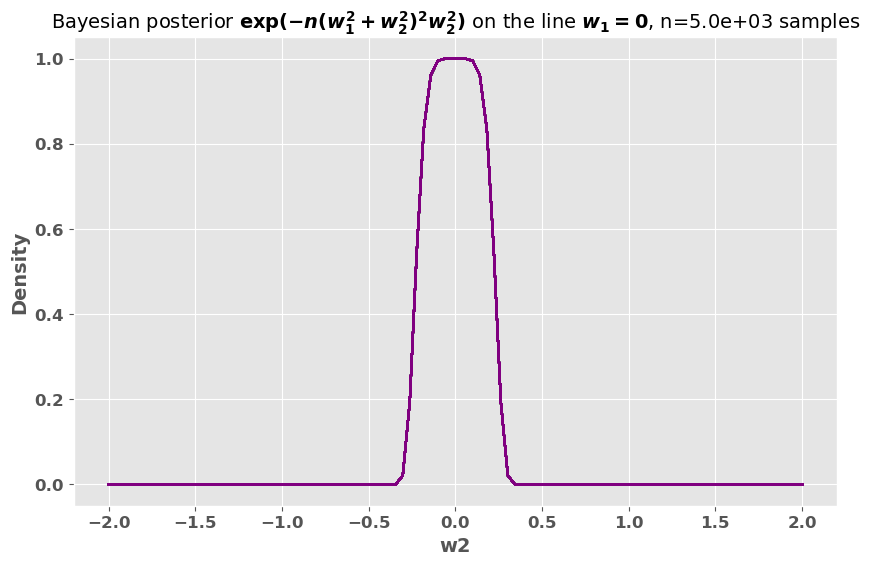

In [108]:
# 2D posterior
from mpl_toolkits.mplot3d import Axes3D

n = niterations
# Create a grid of points
w1 = np.linspace(-2, 2, 100)
w2 = np.linspace(-2, 2, 100)
wx, wy = np.meshgrid(w1, w2)

# Calculate the loss function values
wx = 0
k = (wx**2 + wy**2)**2 * wy**2
post = np.exp(-n*k)
# Create a 3D plot
fig = plt.figure()
plt.plot(wy, post, color="purple")
plt.xlabel('w2')
plt.ylabel('Density')
plt.title(rf'Bayesian posterior $\exp(-n(w_1^2 + w_2^2)^2w_2^2)$ on the line $w_1=0$, n={n:.1e} samples')
# Display the plot
plt.show()

# Loss landscape

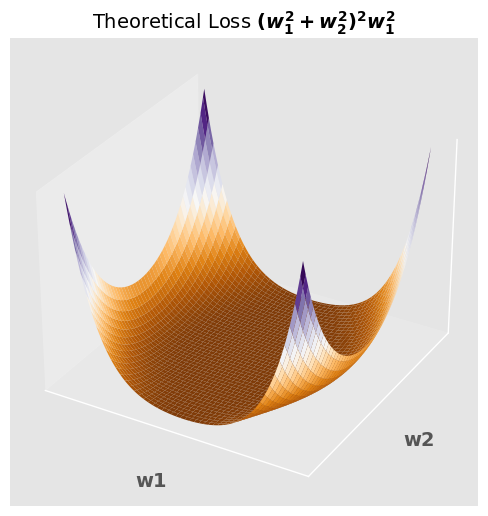

In [98]:
# 2D potential
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of points
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
wx, wy = np.meshgrid(w1, w2)

# Calculate the loss function values
k = (wx**2 + wy**2)**2 * wx**2

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(wx, wy, k, cmap='PuOr')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title(r'Theoretical Loss $(w_1^2 + w_2^2)^2w_1^2$')

# Display the plot
plt.show()

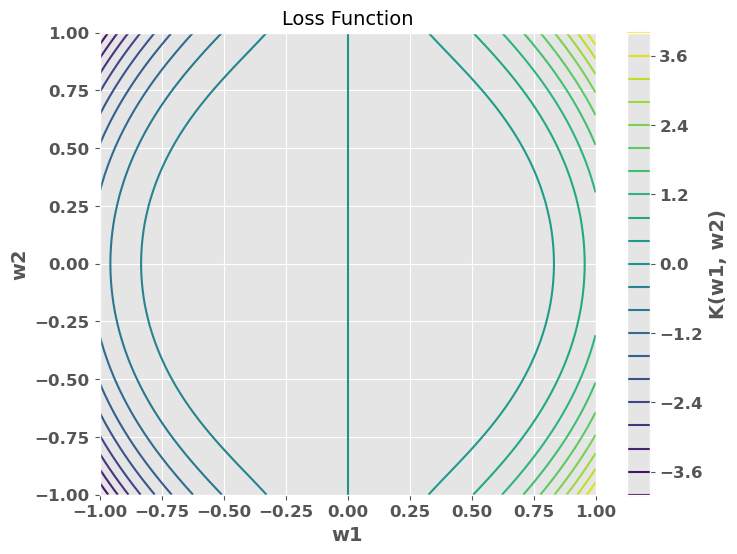

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of points
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

# Calculate the loss function values
K = (W1**2 + W2**2)**2 * W1

# Create a contour plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contour(W1, W2, K, levels=20, cmap='viridis')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_title('Loss Function')

# Add a colorbar
fig.colorbar(contour, ax=ax, label='K(w1, w2)')

# Display the plot
plt.show()

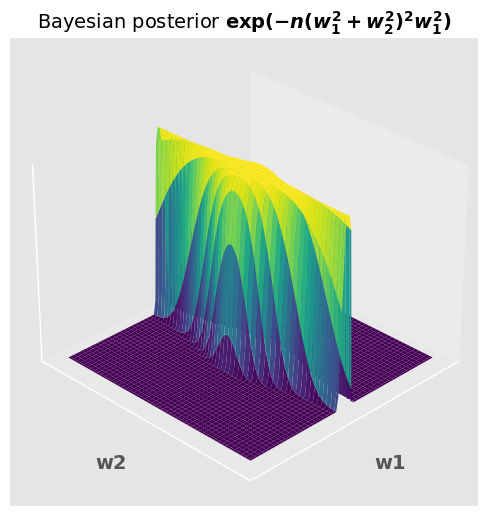

In [38]:
# 2D posterior
from mpl_toolkits.mplot3d import Axes3D

n = nsamples
# Create a grid of points
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
wx, wy = np.meshgrid(w1, w2)

# Calculate the loss function values
k = (wx**2 + wy**2)**2 * wx**4
post = np.exp(-n*k)
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(wx, wy, post, cmap='viridis')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title(r'Bayesian posterior $\exp(-n(w_1^2 + w_2^2)^2w_1^2)$')

# Display the plot
# Set the initial viewing angle
elev = 30  # Elevation angle in degrees
azim = 45  # Azimuth angle in degrees
ax.view_init(elev=elev, azim=azim)

# Display the plot
plt.show()

# Distance to most degenerate minima

In [44]:
# Prepare array
df_clean = df.dropna()
wx = df["trajectory1"].tolist()
wy = df["trajectory2"].tolist()
wx = np.array(wx)
wy = np.array(wy)
W = np.stack((wx, wy), axis=0)
nan_mask = np.isnan(W).any(axis=(0, 2))
W = W[:, ~nan_mask, :]
print(W.shape)

(2, 392, 5001)


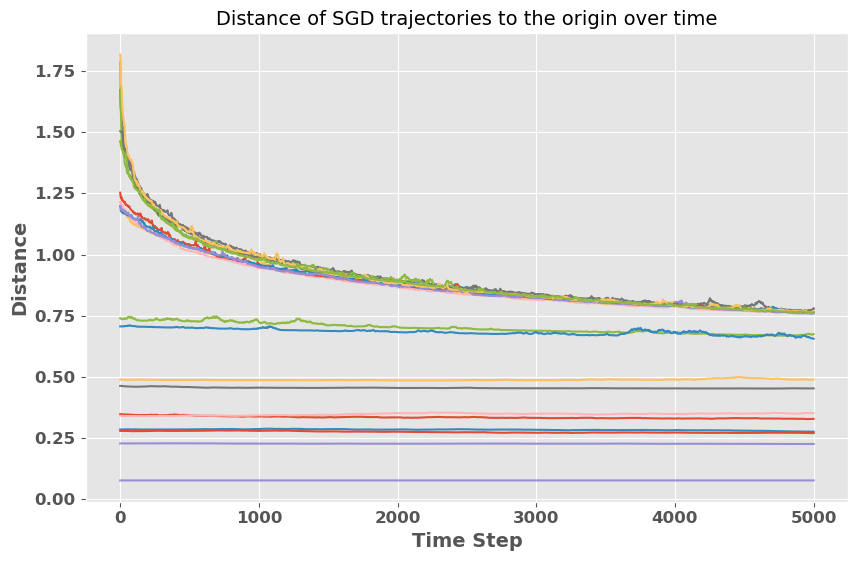

In [93]:
# Extract the x-coordinates and y-coordinates
x_coordinates = W[0]
y_coordinates = W[1]
threshold = 0.75
num_distance = 10
# Compute the Euclidean distance from each point to the origin (0, 0)
distances = np.sqrt(x_coordinates**2 + y_coordinates**2)

# Create a mask for rows where all elements are greater than the threshold
rows_greater_than_threshold = np.all(distances > threshold, axis=1)

# Create a mask for rows where all elements are less than the threshold
rows_less_than_threshold = np.all(distances < threshold, axis=1)

# Apply the masks to get the required subarrays
distances_greater_than_threshold = distances[rows_greater_than_threshold]
distances_less_than_threshold = distances[rows_less_than_threshold]

# Ensure we don't attempt to sample more rows than are available
num_rows_less = distances_less_than_threshold.shape[0]
num_rows_greater = distances_greater_than_threshold.shape[0]

# Sample rows randomly
sampled_less_than_threshold = distances_less_than_threshold[np.random.choice(num_rows_less, min(num_distance, num_rows_less), replace=False)]
sampled_greater_than_threshold = distances_greater_than_threshold[np.random.choice(num_rows_greater, min(num_distance, num_rows_greater), replace=False)]

# Combine the sampled rows into one array
combined_distances = np.vstack((sampled_less_than_threshold, sampled_greater_than_threshold))

combined_distances
# Plot the distances
time = np.arange(W.shape[2])  # Assuming time steps are sequential integers

for i in range(combined_distances.shape[0]):
    plt.plot(time, combined_distances[i, :])
    plt.yscale("linear")

plt.xlabel('Time Step')
plt.ylabel('Distance')
plt.title('Distance of SGD trajectories to the origin over time')
plt.show()

(0.0, 2.0)

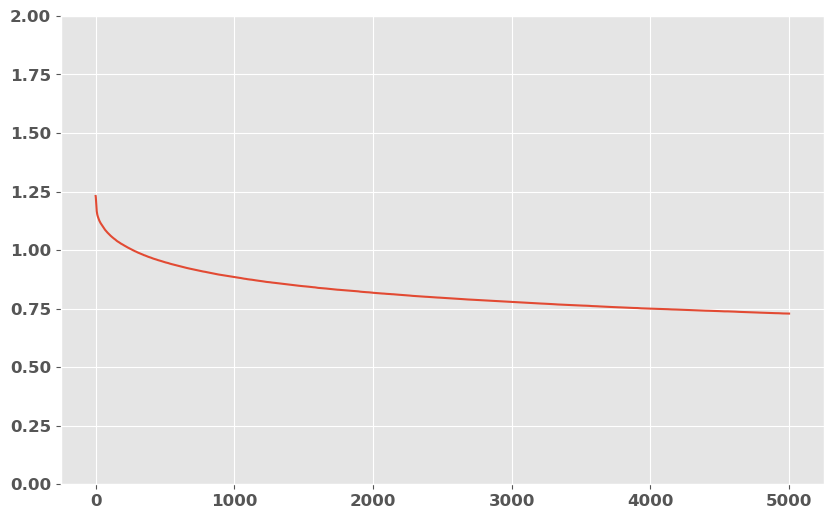

In [60]:
mean_dist = np.mean(distances_greater_than_threshold, axis=0)
plt.plot(time, mean_dist)
plt.yscale('linear')
plt.xscale('linear')
plt.ylim((0, 2))

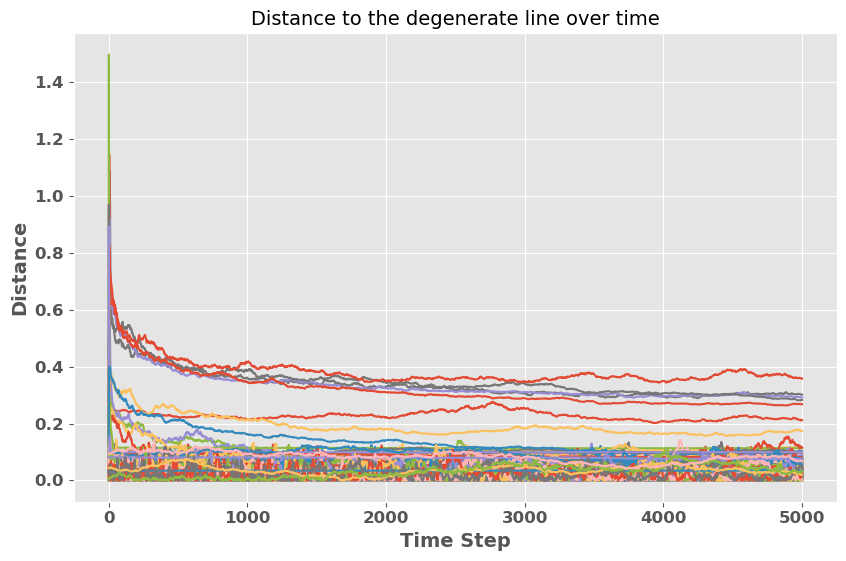

In [88]:
# Distance to L
# Extract the x-coordinates (first row of W)
x_coordinates = W[0]
# Compute the Euclidean distance from each point to the y-axis (x = 0)
# This is simply the absolute value of the x-coordinates

distances = np.abs(x_coordinates)
# Plot the distances
time = np.arange(W.shape[2])  # Assuming time steps are sequential integers

for i in range(distances.shape[0]):
    plt.plot(time, distances[i, :])
    plt.yscale("linear")
    plt.xscale("linear")
plt.xlabel('Time Step')
plt.ylabel('Distance')
plt.title('Distance to the degenerate line over time')
plt.show()

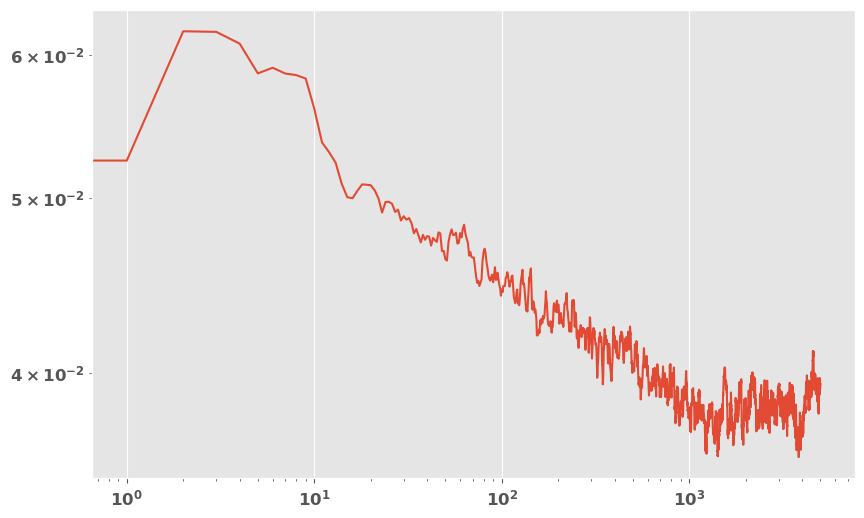

In [65]:
mean_dist = np.mean(distances, axis=0)
plt.plot(time, mean_dist)
plt.yscale('log')
plt.xscale('log')

In [24]:
# Initialise
nSGD = 10*4
nsamples = 10**5
shuffle = True
batch_size= 20
lr = 0.01
seed_init = 1
seed_data = 1
wxm = 1
wym = 1
d=1
model = PolyModel2D(seed=seed_init, wxm=wxm, wym=wym, d=d)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories2d(model)

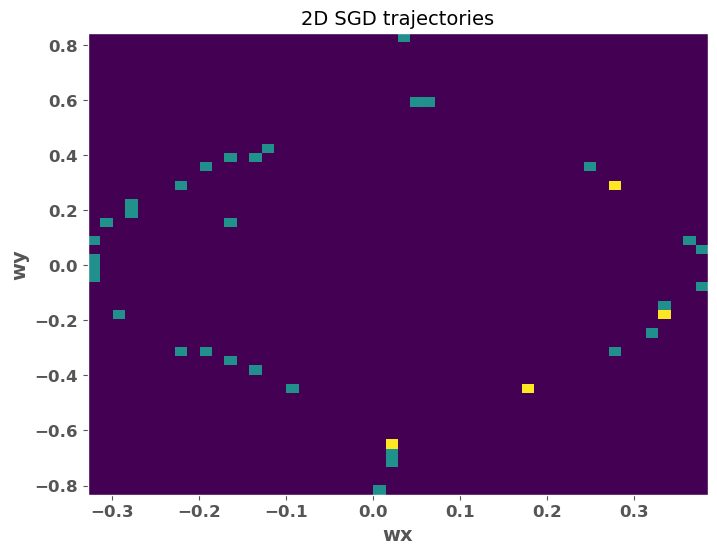

In [25]:
wx = df["trajectory1"].to_list()
wy = df["trajectory2"].to_list()
wx = np.array(wx)
wy = np.array(wy)

wx = wx[:,-1]
wy = wy[:,-1]

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
hist, xedges, yedges, _ = ax.hist2d(wx, wy, bins=50, density=True, cmap='viridis')
ax.set_xlabel('wx')
ax.set_ylabel('wy')
ax.set_title('2D SGD trajectories')
plt.show()

